# F1 Data Management Project v1.1

**Research Question:** How did ground effect regulations and budget cap change car performance in Formula 1?

**Data Sources:**
1. Jolpica API - Qualifying results (API)
2. ENTITY RESOLUTION - Team Name Mapping
3. OpenAI GPT 5mini  - Regulations history (Scraping/data retrival)
4. FIA ATR - Wind tunnel/CFD allocations (API-derived)
5. WDC/WCC Championship Winners (Jolpica API)
6. SQL STORAGE (SQLite) 


**Period:** 2017-2025 (Pre and Post 2022 regulations)

In [3]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

---
## 1. Data Acquisition - Source 1: Qualifying Results (Jolpica API)

In [6]:
def get_all_qualifying(year):
    """Get ALL qualifying results for a year with pagination from Jolpica API"""
    all_results = []
    offset = 0
    limit = 100
    
    while True:
        url = f"https://api.jolpi.ca/ergast/f1/{year}/qualifying.json?limit={limit}&offset={offset}"
        response = requests.get(url)
        data = response.json()
        
        races = data['MRData']['RaceTable']['Races']
        if not races:
            break
            
        for race in races:
            for result in race['QualifyingResults']:
                best_time = result.get('Q3') or result.get('Q2') or result.get('Q1')
                all_results.append({
                    'Year': int(year),
                    'Round': int(race['round']),
                    'GrandPrix': race['raceName'],
                    'Circuit': race['Circuit']['circuitName'],
                    'CircuitID': race['Circuit']['circuitId'],
                    'Position': int(result['position']),
                    'Driver': result['Driver'].get('code', result['Driver']['familyName'][:3].upper()),
                    'DriverName': f"{result['Driver']['givenName']} {result['Driver']['familyName']}",
                    'Team': result['Constructor']['name'],
                    'Q1': result.get('Q1'),
                    'Q2': result.get('Q2'),
                    'Q3': result.get('Q3'),
                    'BestTime': best_time
                })
        
        offset += limit
        total = int(data['MRData']['total'])
        if offset >= total:
            break
        time.sleep(0.3)
    
    return all_results

# Fetch all years
all_data = []
for year in range(2017, 2026):
    results = get_all_qualifying(year)
    all_data.extend(results)
    races_count = len(set(r['Round'] for r in results))
    print(f" {year}: {races_count} races, {len(results)} results")
    time.sleep(0.5)

df_qualifying = pd.DataFrame(all_data)
print(f"\n{'='*50}")
print(f"Total: {len(df_qualifying)} qualifying results")

 2017: 20 races, 398 results
 2018: 21 races, 420 results
 2019: 21 races, 418 results
 2020: 17 races, 340 results
 2021: 22 races, 439 results
 2022: 22 races, 440 results
 2023: 22 races, 440 results
 2024: 24 races, 479 results
 2025: 24 races, 479 results

Total: 3853 qualifying results


In [ ]:
df_qualifying

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,Q2,Q3,BestTime
0,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,1,HAM,Lewis Hamilton,Mercedes,1:24.191,1:23.251,1:22.188,1:22.188
1,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,2,VET,Sebastian Vettel,Ferrari,1:25.210,1:23.401,1:22.456,1:22.456
2,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,3,BOT,Valtteri Bottas,Mercedes,1:24.514,1:23.215,1:22.481,1:22.481
3,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,4,RAI,Kimi Räikkönen,Ferrari,1:24.352,1:23.376,1:23.033,1:23.033
4,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,5,VER,Max Verstappen,Red Bull,1:24.482,1:24.092,1:23.485,1:23.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,16,HAM,Lewis Hamilton,Ferrari,1:23.394,None,None,1:23.394
3849,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,17,ALB,Alexander Albon,Williams,1:23.416,None,None,1:23.416
3850,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,18,HUL,Nico Hülkenberg,Sauber,1:23.450,None,None,1:23.450
3851,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,19,GAS,Pierre Gasly,Alpine F1 Team,1:23.468,None,None,1:23.468


## 2. ENTITY RESOLUTION - Team Name Mapping


In [5]:

TEAM_ENTITY_MAP = {
    # Red Bull B-Team (Toro Rosso → AlphaTauri → RB)
    'Toro Rosso': 'RB F1 Team',
    'Scuderia Toro Rosso': 'RB F1 Team',
    'AlphaTauri': 'RB F1 Team',
    'Scuderia AlphaTauri': 'RB F1 Team',
    'RB F1 Team': 'RB F1 Team',
    
    # Sauber (Sauber → Alfa Romeo → Sauber)
    'Sauber': 'Sauber',
    'Alfa Romeo Sauber F1 Team': 'Sauber',
    'Alfa Romeo': 'Sauber',
    'Alfa Romeo Racing': 'Sauber',
    
    # Force India → Racing Point → Aston Martin
    'Force India': 'Aston Martin',
    'Racing Point': 'Aston Martin',
    'Aston Martin': 'Aston Martin',
    
    # Renault → Alpine
    'Renault': 'Alpine F1 Team',
    'Alpine F1 Team': 'Alpine F1 Team',
    
    # Teams che non cambiano (passthrough)
    'Mercedes': 'Mercedes',
    'Red Bull': 'Red Bull',
    'Ferrari': 'Ferrari',
    'McLaren': 'McLaren',
    'Williams': 'Williams',
    'Haas F1 Team': 'Haas F1 Team',
    
    # Defunct teams (2017 only)
    'Lotus F1': 'Lotus F1',
    'Manor Marussia': 'Manor Marussia',
}

def resolve_team_entity(team_name):
    """Resolve team name to canonical entity"""
    return TEAM_ENTITY_MAP.get(team_name, team_name)

# Apply entity resolution
df_qualifying['Team_Entity'] = df_qualifying['Team'].apply(resolve_team_entity)

# Verify counts
print("Entity Resolution Applied:")
print(df_qualifying.groupby(['Team', 'Team_Entity']).size().reset_index(name='count'))

NameError: name 'df_qualifying' is not defined

## 3. LLM regulations extraction

In [ ]:
import os
from getpass import getpass

# Chiede la chiave solo se non è già impostata (chiavi ingiustamente non rubate)
if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass("Inserisci OpenAI API Key: ")

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [10]:
# ===================================================================
# F1 REGULATION EXTRACTION via OpenAI API
# ===================================================================
import openai
import json
import time
import pandas as pd
import numpy as np
import os
from getpass import getpass

# OpenAI API Configuration
if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass("Inserisci OpenAI API Key: ")

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_MODEL = 'gpt-5-mini-2025-08-07'
openai.api_key = OPENAI_API_KEY

def get_regulations_from_openai(year):
    '''Use OpenAI API to extract F1 regulation changes for a given year'''
    prompt = f'''For {year} F1 season, list main regulation changes.
Return JSON array: [{{"Year": {year}, "Type": "Aero/Financial/Safety/Engine", "Description": "...", "Impact": "Major/Minor/Revolutionary", "Source": "FIA {year}"}}].
Only JSON.'''
    
    response = openai.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[{'role': 'user', 'content': prompt}],
    )
    return response.choices[0].message.content

# Extract regulations for each year using OpenAI API
print(f'Extracting F1 regulations via OpenAI API ({OPENAI_MODEL})...')
print('='*60)

all_regulations = []
for year in range(2017, 2026):  # Iterazione diretta sugli anni!
    print(f'{year}...', end=' ')
    try:
        result = get_regulations_from_openai(year)
        result = result.strip()
        if result.startswith('```json'): result = result[7:]
        if result.startswith('```'): result = result[3:]
        if result.endswith('```'): result = result[:-3]
        
        regs = json.loads(result.strip())
        all_regulations.extend(regs)
        print(f'{len(regs)} regulations extracted')
    except Exception as e:
        print(f'Error: {e}')
    
    time.sleep(1)

# Create DataFrame
df_regulations = pd.DataFrame(all_regulations)
df_regulations['Era'] = np.where(df_regulations['Year'] < 2022, 'Pre-2022', 'Post-2022')
df_regulations['Extraction_Method'] = f'OpenAI API ({OPENAI_MODEL})'

# Save to CSV
df_regulations.to_csv('f1_regulations_openai.csv', index=False)

print('='*60)
print(f'Regulations dataset: {len(df_regulations)} entries extracted via {OPENAI_MODEL}')
df_regulations

Extracting F1 regulations via OpenAI API (gpt-5-mini-2025-08-07)...
2017... 6 regulations extracted
2018... 5 regulations extracted
2019... 4 regulations extracted
2020... 4 regulations extracted
2021... 4 regulations extracted
2022... 8 regulations extracted
2023... 7 regulations extracted
2024... 4 regulations extracted
2025... 4 regulations extracted
Regulations dataset: 46 entries extracted via gpt-5-mini-2025-08-07


,Year,Type,Description,Impact,Source,Era,Extraction_Method
0,2017,Aero,Comprehensive aerodynamic overhaul for 2017: c...,Revolutionary,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
1,2017,Aero,Tyre and wheel regulation changes: significant...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
2,2017,Aero,Car dimensional and mass adjustments: overall ...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
3,2017,Engine,Power unit rules largely carried over from pri...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
4,2017,Safety,Incremental safety rule updates: ongoing tight...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
5,2017,Financial,No new cost-cap or major financial redistribut...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
6,2018,Safety,Mandatory introduction of the 'halo' cockpit p...,Major,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
7,2018,Safety,Revised cockpit and chassis test procedures an...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
8,2018,Engine,Continuation and enforcement of power unit dev...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
9,2018,Aero,Technical clarifications and targeted adjustme...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)


LOAD REGULATIONS EXTRACTED via OpenAI API (gpt-5-mini-2025-08-07)

In [7]:
# Model: OpenAI API (gpt-5-mini-2025-08-07)

df_regulations = pd.read_csv('f1_regulations_openai.csv')
df_regulations['Era'] = df_regulations['Year'].apply(lambda x: 'Pre-2022' if x < 2022 else 'Post-2022')

print(f"Loaded {len(df_regulations)} regulations from OpenAI extraction")
df_regulations

Loaded 46 regulations from OpenAI extraction


,Year,Type,Description,Impact,Source,Era,Extraction_Method
0,2017,Aero,Comprehensive aerodynamic overhaul for 2017: c...,Revolutionary,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
1,2017,Aero,Tyre and wheel regulation changes: significant...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
2,2017,Aero,Car dimensional and mass adjustments: overall ...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
3,2017,Engine,Power unit rules largely carried over from pri...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
4,2017,Safety,Incremental safety rule updates: ongoing tight...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
5,2017,Financial,No new cost-cap or major financial redistribut...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
6,2018,Safety,Mandatory introduction of the 'halo' cockpit p...,Major,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
7,2018,Safety,Revised cockpit and chassis test procedures an...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
8,2018,Engine,Continuation and enforcement of power unit dev...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
9,2018,Aero,Technical clarifications and targeted adjustme...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)



## 4. ATR Allocations (Jolpica API) 

In [8]:
# ATR allocation percentages (based on previous year's position)
# Source: FIA Aerodynamic Testing Regulations
atr_percentages = {
    1: 0.70, 2: 0.75, 3: 0.80, 4: 0.85, 5: 0.90,
    6: 0.95, 7: 1.00, 8: 1.05, 9: 1.10, 10: 1.15
}

BASELINE_WT_RUNS = 320
BASELINE_CFD_ITEMS = 2000
ATR_PERIODS_PER_YEAR = 6

def get_constructor_standings(year):
    """Get constructor standings from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/constructorStandings.json"
    response = requests.get(url)
    data = response.json()
    standings = data['MRData']['StandingsTable']['StandingsLists']
    if not standings:
        return None
    return standings[0]['ConstructorStandings']

# Build ATR database (2022-2025)
atr_data = []
for year in range(2022, 2026):
    prev_standings = get_constructor_standings(year - 1)
    
    if prev_standings is None:
        continue
    
    for standing in prev_standings:
        position = int(standing['position'])
        team = standing['Constructor']['name']
        
        pct = atr_percentages.get(position, 1.0)
        wt_runs_per_period = int(BASELINE_WT_RUNS * pct)
        cfd_per_period = int(BASELINE_CFD_ITEMS * pct)
        
        atr_data.append({
            'Year': year,
            'Team': team,
            'PreviousPosition': position,
            'ATR_Percentage': pct * 100,
            'WT_RunsPerPeriod': wt_runs_per_period,
            'WT_RunsAnnual': wt_runs_per_period * ATR_PERIODS_PER_YEAR,
            'CFD_ItemsPerPeriod': cfd_per_period,
            'CFD_ItemsAnnual': cfd_per_period * ATR_PERIODS_PER_YEAR,
            'Source': 'Jolpica API + FIA ATR'
        })
    
    print(f" {year} ATR allocations calculated from API/rules")
    time.sleep(0.3)

df_atr = pd.DataFrame(atr_data)
print(f"\n ATR dataset: {len(df_atr)} entries from Jolpica API")

 2022 ATR allocations calculated from API/rules
 2023 ATR allocations calculated from API/rules
 2024 ATR allocations calculated from API/rules
 2025 ATR allocations calculated from API/rules

 ATR dataset: 40 entries from Jolpica API


In [9]:
df_atr

,Year,Team,PreviousPosition,ATR_Percentage,WT_RunsPerPeriod,WT_RunsAnnual,CFD_ItemsPerPeriod,CFD_ItemsAnnual,Source
0,2022,Mercedes,1,70.0,224,1344,1400,8400,Jolpica API + FIA ATR
1,2022,Red Bull,2,75.0,240,1440,1500,9000,Jolpica API + FIA ATR
2,2022,Ferrari,3,80.0,256,1536,1600,9600,Jolpica API + FIA ATR
3,2022,McLaren,4,85.0,272,1632,1700,10200,Jolpica API + FIA ATR
4,2022,Alpine F1 Team,5,90.0,288,1728,1800,10800,Jolpica API + FIA ATR
5,2022,AlphaTauri,6,95.0,304,1824,1900,11400,Jolpica API + FIA ATR
6,2022,Aston Martin,7,100.0,320,1920,2000,12000,Jolpica API + FIA ATR
7,2022,Williams,8,105.0,336,2016,2100,12600,Jolpica API + FIA ATR
8,2022,Alfa Romeo,9,110.0,352,2112,2200,13200,Jolpica API + FIA ATR
9,2022,Haas F1 Team,10,115.0,368,2208,2300,13800,Jolpica API + FIA ATR



## 5. Data Preparation

In [10]:
def time_to_seconds(time_str):
    """Convert qualifying time string (M:SS.mmm) to seconds"""
    if pd.isna(time_str) or time_str is None:
        return None
    try:
        parts = time_str.split(':')
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    except:
        return None

# Apply conversion
df_qualifying['BestTime_Seconds'] = df_qualifying['BestTime'].apply(time_to_seconds)

# Get pole time per race
df_qualifying['PoleTime'] = df_qualifying.groupby(['Year', 'Round'])['BestTime_Seconds'].transform('min')

# Calculate gap to pole
df_qualifying['GapToPole'] = df_qualifying['BestTime_Seconds'] - df_qualifying['PoleTime']

# Add era column
df_qualifying['Era'] = df_qualifying['Year'].apply(lambda x: 'Pre-2022' if x < 2022 else 'Post-2022')

print(" Time conversion and gap calculation complete")

 Time conversion and gap calculation complete


In [11]:
df_qualifying

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,Q2,Q3,BestTime,BestTime_Seconds,PoleTime,GapToPole,Era
0,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,1,HAM,Lewis Hamilton,Mercedes,1:24.191,1:23.251,1:22.188,1:22.188,82.188,82.188,0.000,Pre-2022
1,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,2,VET,Sebastian Vettel,Ferrari,1:25.210,1:23.401,1:22.456,1:22.456,82.456,82.188,0.268,Pre-2022
2,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,3,BOT,Valtteri Bottas,Mercedes,1:24.514,1:23.215,1:22.481,1:22.481,82.481,82.188,0.293,Pre-2022
3,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,4,RAI,Kimi Räikkönen,Ferrari,1:24.352,1:23.376,1:23.033,1:23.033,83.033,82.188,0.845,Pre-2022
4,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,5,VER,Max Verstappen,Red Bull,1:24.482,1:24.092,1:23.485,1:23.485,83.485,82.188,1.297,Pre-2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,16,HAM,Lewis Hamilton,Ferrari,1:23.394,None,None,1:23.394,83.394,82.207,1.187,Post-2022
3849,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,17,ALB,Alexander Albon,Williams,1:23.416,None,None,1:23.416,83.416,82.207,1.209,Post-2022
3850,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,18,HUL,Nico Hülkenberg,Sauber,1:23.450,None,None,1:23.450,83.450,82.207,1.243,Post-2022
3851,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,19,GAS,Pierre Gasly,Alpine F1 Team,1:23.468,None,None,1:23.468,83.468,82.207,1.261,Post-2022


In [11]:
df_2025=(df_qualifying['Year']==2025 ) & (df_qualifying['CircuitID']=='monza')
df_2025=df_qualifying[df_2025]
df_2025.head(10)

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,Q2,Q3,BestTime,Team_Entity,BestTime_Seconds,PoleTime,GapToPole,Era
3674,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,1,VER,Max Verstappen,Red Bull,1:19.455,1:19.140,1:18.792,1:18.792,Red Bull,78.792,78.792,0.000,Post-2022
3675,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,2,NOR,Lando Norris,McLaren,1:19.517,1:19.293,1:18.869,1:18.869,McLaren,78.869,78.792,0.077,Post-2022
3676,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,3,PIA,Oscar Piastri,McLaren,1:19.711,1:19.286,1:18.982,1:18.982,McLaren,78.982,78.792,0.190,Post-2022
3677,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,4,LEC,Charles Leclerc,Ferrari,1:19.689,1:19.310,1:19.007,1:19.007,Ferrari,79.007,78.792,0.215,Post-2022
3678,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,5,HAM,Lewis Hamilton,Ferrari,1:19.765,1:19.371,1:19.124,1:19.124,Ferrari,79.124,78.792,0.332,Post-2022
3679,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,6,RUS,George Russell,Mercedes,1:19.414,1:19.287,1:19.157,1:19.157,Mercedes,79.157,78.792,0.365,Post-2022
3680,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,7,ANT,Andrea Kimi Antonelli,Mercedes,1:19.747,1:19.245,1:19.200,1:19.200,Mercedes,79.200,78.792,0.408,Post-2022
3681,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,8,BOR,Gabriel Bortoleto,Sauber,1:19.688,1:19.323,1:19.390,1:19.390,Sauber,79.390,78.792,0.598,Post-2022
3682,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,9,ALO,Fernando Alonso,Aston Martin,1:19.658,1:19.362,1:19.424,1:19.424,Aston Martin,79.424,78.792,0.632,Post-2022
3683,2025,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,10,TSU,Yuki Tsunoda,Red Bull,1:19.619,1:19.433,1:19.519,1:19.519,Red Bull,79.519,78.792,0.727,Post-2022


In [12]:
df_2021=(df_qualifying['Year']==2021 ) & (df_qualifying['CircuitID']=='monza')
df_2021=df_qualifying[df_2021]
df_2021.head(10)

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,Q2,Q3,BestTime,Team_Entity,BestTime_Seconds,PoleTime,GapToPole,Era
1835,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,1,BOT,Valtteri Bottas,Mercedes,1:20.685,1:20.032,1:19.555,1:19.555,Mercedes,79.555,79.555,0.000,Pre-2022
1836,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,2,HAM,Lewis Hamilton,Mercedes,1:20.543,1:19.936,1:19.651,1:19.651,Mercedes,79.651,79.555,0.096,Pre-2022
1837,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,3,VER,Max Verstappen,Red Bull,1:21.035,1:20.229,1:19.966,1:19.966,Red Bull,79.966,79.555,0.411,Pre-2022
1838,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,4,NOR,Lando Norris,McLaren,1:20.916,1:20.059,1:19.989,1:19.989,McLaren,79.989,79.555,0.434,Pre-2022
1839,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,5,RIC,Daniel Ricciardo,McLaren,1:21.292,1:20.435,1:19.995,1:19.995,McLaren,79.995,79.555,0.440,Pre-2022
1840,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,6,GAS,Pierre Gasly,AlphaTauri,1:21.440,1:20.556,1:20.260,1:20.260,RB F1 Team,80.260,79.555,0.705,Pre-2022
1841,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,7,SAI,Carlos Sainz,Ferrari,1:21.118,1:20.750,1:20.462,1:20.462,Ferrari,80.462,79.555,0.907,Pre-2022
1842,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,8,LEC,Charles Leclerc,Ferrari,1:21.219,1:20.767,1:20.510,1:20.510,Ferrari,80.510,79.555,0.955,Pre-2022
1843,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,9,PER,Sergio Pérez,Red Bull,1:21.308,1:20.882,1:20.611,1:20.611,Red Bull,80.611,79.555,1.056,Pre-2022
1844,2021,14,Italian Grand Prix,Autodromo Nazionale di Monza,monza,10,GIO,Antonio Giovinazzi,Alfa Romeo,1:21.197,1:20.726,1:20.808,1:20.808,Sauber,80.808,79.555,1.253,Pre-2022



## 6. Data Integration

In [13]:
# Create regulations summary per year
reg_summary = df_regulations.groupby('Year').agg(
    RegulationChanges=('Description', 'count'),
    MajorChanges=('Impact', lambda x: (x.isin(['Major', 'Revolutionary'])).sum()),
    HasRevolutionary=('Impact', lambda x: 'Yes' if 'Revolutionary' in x.values else 'No')
).reset_index()

# Merge regulations summary with qualifying data
df_qualifying = df_qualifying.merge(reg_summary, on='Year', how='left')

# Merge ATR allocations with qualifying data
df_qualifying = df_qualifying.merge(
    df_atr[['Year', 'Team', 'ATR_Percentage', 'WT_RunsAnnual', 'CFD_ItemsAnnual']], 
    on=['Year', 'Team'], 
    how='left'
)

print(f" Integrated dataset: {len(df_qualifying)} rows, {len(df_qualifying.columns)} columns")
print(f"\nData Sources Integrated:")
print("  1. Jolpica API - Qualifying results")
print("  2. Jolpica API - ATR allocations (derived)")

 Integrated dataset: 3853 rows, 29 columns

Data Sources Integrated:
  1. Jolpica API - Qualifying results
  2. Jolpica API - ATR allocations (derived)


In [14]:
df_qualifying

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,...,BestTime_Seconds,PoleTime,GapToPole,Era,RegulationChanges,MajorChanges,HasRevolutionary,ATR_Percentage,WT_RunsAnnual,CFD_ItemsAnnual
0,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,1,HAM,Lewis Hamilton,Mercedes,1:24.191,...,82.188,82.188,0.000,Pre-2022,6,3,Yes,NaN,NaN,NaN
1,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,2,VET,Sebastian Vettel,Ferrari,1:25.210,...,82.456,82.188,0.268,Pre-2022,6,3,Yes,NaN,NaN,NaN
2,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,3,BOT,Valtteri Bottas,Mercedes,1:24.514,...,82.481,82.188,0.293,Pre-2022,6,3,Yes,NaN,NaN,NaN
3,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,4,RAI,Kimi Räikkönen,Ferrari,1:24.352,...,83.033,82.188,0.845,Pre-2022,6,3,Yes,NaN,NaN,NaN
4,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,5,VER,Max Verstappen,Red Bull,1:24.482,...,83.485,82.188,1.297,Pre-2022,6,3,Yes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,16,HAM,Lewis Hamilton,Ferrari,1:23.394,...,83.394,82.207,1.187,Post-2022,4,0,No,75.0,1440.0,9000.0
3849,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,17,ALB,Alexander Albon,Williams,1:23.416,...,83.416,82.207,1.209,Post-2022,4,0,No,110.0,2112.0,13200.0
3850,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,18,HUL,Nico Hülkenberg,Sauber,1:23.450,...,83.450,82.207,1.243,Post-2022,4,0,No,115.0,2208.0,13800.0
3851,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,19,GAS,Pierre Gasly,Alpine F1 Team,1:23.468,...,83.468,82.207,1.261,Post-2022,4,0,No,95.0,1824.0,11400.0


In [14]:
df_2021=(df_qualifying['Year']==2022 ) & (df_qualifying['CircuitID']=='monza')
df_2021=df_qualifying[df_2021]
df_2021.head(10)

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,...,HasRevolutionary_x,ATR_Percentage_x,WT_RunsAnnual_x,CFD_ItemsAnnual_x,RegulationChanges_y,MajorChanges_y,HasRevolutionary_y,ATR_Percentage_y,WT_RunsAnnual_y,CFD_ItemsAnnual_y
2315,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,1,LEC,Charles Leclerc,Ferrari,1:21.280,...,Yes,80.0,1536.0,9600.0,8,6,Yes,80.0,1536.0,9600.0
2316,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,2,VER,Max Verstappen,Red Bull,1:20.922,...,Yes,75.0,1440.0,9000.0,8,6,Yes,75.0,1440.0,9000.0
2317,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,3,SAI,Carlos Sainz,Ferrari,1:21.348,...,Yes,80.0,1536.0,9600.0,8,6,Yes,80.0,1536.0,9600.0
2318,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,4,PER,Sergio Pérez,Red Bull,1:21.495,...,Yes,75.0,1440.0,9000.0,8,6,Yes,75.0,1440.0,9000.0
2319,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,5,HAM,Lewis Hamilton,Mercedes,1:22.048,...,Yes,70.0,1344.0,8400.0,8,6,Yes,70.0,1344.0,8400.0
2320,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,6,RUS,George Russell,Mercedes,1:21.785,...,Yes,70.0,1344.0,8400.0,8,6,Yes,70.0,1344.0,8400.0
2321,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,7,NOR,Lando Norris,McLaren,1:22.130,...,Yes,85.0,1632.0,10200.0,8,6,Yes,85.0,1632.0,10200.0
2322,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,8,RIC,Daniel Ricciardo,McLaren,1:22.139,...,Yes,85.0,1632.0,10200.0,8,6,Yes,85.0,1632.0,10200.0
2323,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,9,GAS,Pierre Gasly,AlphaTauri,1:22.010,...,Yes,95.0,1824.0,11400.0,8,6,Yes,95.0,1824.0,11400.0
2324,2022,16,Italian Grand Prix,Autodromo Nazionale di Monza,monza,10,ALO,Fernando Alonso,Alpine F1 Team,1:22.089,...,Yes,90.0,1728.0,10800.0,8,6,Yes,90.0,1728.0,10800.0



## 7. Data Quality Assessment

In [16]:
def calculate_data_quality(df, name, exclude_cols=None):
    """Calculate data quality metrics, optionally excluding columns from completeness"""
    
    if exclude_cols:
        df_check = df.drop(columns=exclude_cols, errors='ignore')
    else:
        df_check = df
    
    total_cells = df_check.size
    null_cells = df_check.isnull().sum().sum()
    completeness = (1 - null_cells / total_cells) * 100
    
    col_completeness = (1 - df.isnull().sum() / len(df)) * 100
    
    print(f"\n=== Data Quality Report: {name} ===")
    print(f"Total Records: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    if exclude_cols:
        print(f"Excluded from completeness: {exclude_cols} (structural nulls)")
    print(f"Overall Completeness: {completeness:.2f}%")
    print(f"\nPer-column Completeness:")
    for col, comp in col_completeness.items():
        status = " (expected)" if exclude_cols and col in exclude_cols else ""
        print(f"  {col}: {comp:.1f}%{status}")
    
    return {
        'Dataset': name,
        'Records': len(df),
        'Columns': len(df.columns),
        'Completeness': completeness
    }

quality_results = []
# Escludi Q2/Q3 - i null sono strutturali (solo 15 e 10 piloti rispettivamente)
quality_results.append(calculate_data_quality(df_qualifying, 'Qualifying', exclude_cols=['Q2', 'Q3', 'ATR_Percentage', 'WT_RunsAnnual', 'CFD_ItemsAnnual']))
quality_results.append(calculate_data_quality(df_regulations, 'Regulations'))
quality_results.append(calculate_data_quality(df_atr, 'ATR Allocations'))

df_quality = pd.DataFrame(quality_results)
print(f"\n=== Summary ===")
df_quality


=== Data Quality Report: Qualifying ===
Total Records: 3853
Total Columns: 29
Excluded from completeness: ['Q2', 'Q3', 'ATR_Percentage', 'WT_RunsAnnual', 'CFD_ItemsAnnual'] (structural nulls)
Overall Completeness: 87.68%

Per-column Completeness:
  Year: 100.0%
  Round: 100.0%
  GrandPrix: 100.0%
  Circuit: 100.0%
  CircuitID: 100.0%
  Position: 100.0%
  Driver: 100.0%
  DriverName: 100.0%
  Team: 100.0%
  Q1: 100.0%
  Q2: 74.1% (expected)
  Q3: 49.3% (expected)
  BestTime: 100.0%
  BestTime_Seconds: 98.4%
  PoleTime: 99.5%
  GapToPole: 98.4%
  Era: 100.0%
  RegulationChanges_x: 100.0%
  MajorChanges_x: 100.0%
  HasRevolutionary_x: 100.0%
  ATR_Percentage_x: 45.2%
  WT_RunsAnnual_x: 45.2%
  CFD_ItemsAnnual_x: 45.2%
  RegulationChanges_y: 100.0%
  MajorChanges_y: 100.0%
  HasRevolutionary_y: 100.0%
  ATR_Percentage_y: 45.2%
  WT_RunsAnnual_y: 45.2%
  CFD_ItemsAnnual_y: 45.2%

=== Data Quality Report: Regulations ===
Total Records: 46
Total Columns: 7
Overall Completeness: 100.00%

Per-

,Dataset,Records,Columns,Completeness
0,Qualifying,3853,29,87.68444
1,Regulations,46,7,100.00000
2,ATR Allocations,40,9,100.00000


In [21]:
def calculate_data_quality(df, name, exclude_cols=None):
    """Calculate data quality metrics, optionally excluding columns from completeness"""
    
    if exclude_cols:
        df_check = df.drop(columns=exclude_cols, errors='ignore')
    else:
        df_check = df
    
    total_cells = df_check.size
    null_cells = df_check.isnull().sum().sum()
    completeness = (1 - null_cells / total_cells) * 100
    
    # Calcolo completeness su TUTTE le colonne (per confronto)
    total_cells_all = df.size
    null_cells_all = df.isnull().sum().sum()
    raw_completeness = (1 - null_cells_all / total_cells_all) * 100
    
    col_completeness = (1 - df.isnull().sum() / len(df)) * 100
    
    print(f"\n=== Data Quality Report: {name} ===")
    print(f"Total Records: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    if exclude_cols:
        print(f"Excluded from completeness: {exclude_cols} (structural nulls)")
        print(f"Raw Completeness (all columns): {raw_completeness:.2f}%")
        print(f"Adjusted Completeness (excluding structural nulls): {completeness:.2f}%")
    else:
        print(f"Overall Completeness: {completeness:.2f}%")
    print(f"\nPer-column Completeness:")
    for col, comp in col_completeness.items():
        status = " (structural null)" if exclude_cols and col in exclude_cols else ""
        print(f"  {col}: {comp:.1f}%{status}")
    
    return {
        'Dataset': name,
        'Records': len(df),
        'Columns': len(df.columns),
        'Raw_Completeness': raw_completeness if exclude_cols else completeness,
        'Adjusted_Completeness': completeness
    }

In [23]:
quality_results = []
quality_results.append(calculate_data_quality(
    df_qualifying, 
    'Qualifying', 
    exclude_cols=['Q2', 'Q3', 
                  'ATR_Percentage_x', 'ATR_Percentage_y',
                  'WT_RunsAnnual_x', 'WT_RunsAnnual_y', 
                  'CFD_ItemsAnnual_x', 'CFD_ItemsAnnual_y']
))
quality_results.append(calculate_data_quality(df_regulations, 'Regulations'))
quality_results.append(calculate_data_quality(df_atr, 'ATR Allocations'))

df_quality = pd.DataFrame(quality_results)
print(f"\n=== Summary ===")
df_quality


=== Data Quality Report: Qualifying ===
Total Records: 3853
Total Columns: 29
Excluded from completeness: ['Q2', 'Q3', 'ATR_Percentage_x', 'ATR_Percentage_y', 'WT_RunsAnnual_x', 'WT_RunsAnnual_y', 'CFD_ItemsAnnual_x', 'CFD_ItemsAnnual_y'] (structural nulls)
Raw Completeness (all columns): 85.89%
Adjusted Completeness (excluding structural nulls): 99.82%

Per-column Completeness:
  Year: 100.0%
  Round: 100.0%
  GrandPrix: 100.0%
  Circuit: 100.0%
  CircuitID: 100.0%
  Position: 100.0%
  Driver: 100.0%
  DriverName: 100.0%
  Team: 100.0%
  Q1: 100.0%
  Q2: 74.1% (structural null)
  Q3: 49.3% (structural null)
  BestTime: 100.0%
  BestTime_Seconds: 98.4%
  PoleTime: 99.5%
  GapToPole: 98.4%
  Era: 100.0%
  RegulationChanges_x: 100.0%
  MajorChanges_x: 100.0%
  HasRevolutionary_x: 100.0%
  ATR_Percentage_x: 45.2% (structural null)
  WT_RunsAnnual_x: 45.2% (structural null)
  CFD_ItemsAnnual_x: 45.2% (structural null)
  RegulationChanges_y: 100.0%
  MajorChanges_y: 100.0%
  HasRevolutiona

,Dataset,Records,Columns,Raw_Completeness,Adjusted_Completeness
0,Qualifying,3853,29,85.890976,99.819559
1,Regulations,46,7,100.000000,100.000000
2,ATR Allocations,40,9,100.000000,100.000000



## 8. Analysis - Field Spread by Era

In [29]:
# Field spread: gap between P1 and P10 per race
top10 = df_qualifying[df_qualifying['Position'] <= 10]
field_spread = top10.groupby(['Year', 'Round', 'GrandPrix', 'Era']).agg(
    P1_Time=('BestTime_Seconds', 'min'),
    P10_Time=('BestTime_Seconds', 'max'),
    Spread=('GapToPole', 'max')
).reset_index()

print("Average P1-P10 spread by era:")
era_spread = field_spread.groupby('Era')['Spread'].mean()
print(era_spread)

# Yearly trend
yearly_spread = field_spread.groupby('Year')['Spread'].mean()
print("\nYearly spread:")
print(yearly_spread)

Average P1-P10 spread by era:
Era
Post-2022    2.150098
Pre-2022     2.722120
Name: Spread, dtype: float64

Yearly spread:
Year
2017    2.291750
2018    4.401381
2019    2.028762
2020    2.111250
2021    2.616545
2022    3.667318
2023    1.980727
2024    1.952417
2025    1.112250
Name: Spread, dtype: float64


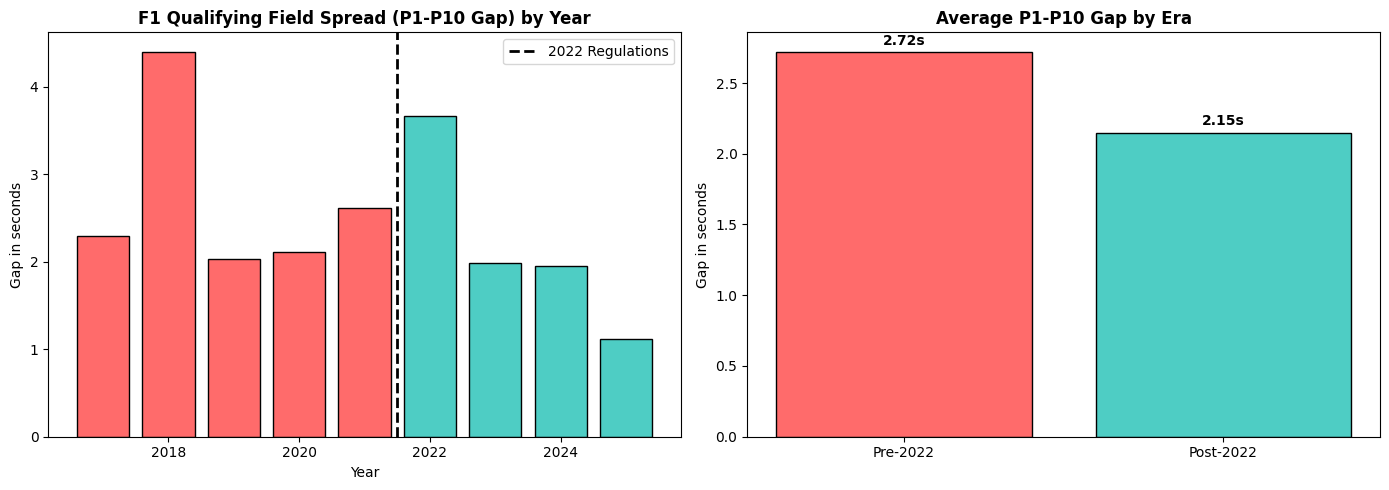

In [23]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Field Spread by Year
years = yearly_spread.index
spreads = yearly_spread.values
colors = ['#FF6B6B' if y < 2022 else '#4ECDC4' for y in years]

axes[0].bar(years, spreads, color=colors, edgecolor='black')
axes[0].axvline(x=2021.5, color='black', linestyle='--', linewidth=2, label='2022 Regulations')
axes[0].set_title('F1 Qualifying Field Spread (P1-P10 Gap) by Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Gap in seconds')
axes[0].set_xlabel('Year')
axes[0].legend()

# Plot 2: Era Comparison - ORDER: Pre-2022 (left), Post-2022 (right)
era_order = ['Pre-2022', 'Post-2022']
era_values = [era_spread['Pre-2022'], era_spread['Post-2022']]
era_colors = ['#FF6B6B', '#4ECDC4']  # Red for Pre, Teal for Post

axes[1].bar(era_order, era_values, color=era_colors, edgecolor='black')
axes[1].set_title('Average P1-P10 Gap by Era', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Gap in seconds')
for i, (era, val) in enumerate(zip(era_order, era_values)):
    axes[1].text(i, val + 0.05, f'{val:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('f1_field_spread_analysis.png', dpi=150)
plt.show()


## 9. Storage & Export

In [18]:
# Save all datasets
df_qualifying.to_csv('f1_qualifying_complete.csv', index=False)
df_qualifying.to_parquet('f1_qualifying_complete.parquet', index=False)

df_regulations.to_csv('f1_regulations_changes.csv', index=False)
df_atr.to_csv('f1_atr_allocations.csv', index=False)

field_spread.to_csv('f1_field_spread.csv', index=False)
df_quality.to_csv('f1_data_quality_report.csv', index=False)

print(" All datasets saved!")
print(f"\nFiles created:")
print(f"  - f1_qualifying_complete.csv ({len(df_qualifying)} rows)")
print(f"  - f1_regulations_changes.csv ({len(df_regulations)} rows)")
print(f"  - f1_atr_allocations.csv ({len(df_atr)} rows)")
print(f"  - f1_field_spread.csv ({len(field_spread)} rows)")
print(f"  - f1_data_quality_report.csv")
print(f"  - f1_field_spread_analysis.png")

 All datasets saved!

Files created:
  - f1_qualifying_complete.csv (3853 rows)
  - f1_regulations_changes.csv (46 rows)
  - f1_atr_allocations.csv (40 rows)
  - f1_field_spread.csv (193 rows)
  - f1_data_quality_report.csv
  - f1_field_spread_analysis.png


# Source 4: WDC/WCC Championship Winners (Jolpica API)

In [19]:

def get_driver_standings_winner(year):
    """Get WDC winner from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/driverstandings/1.json"
    response = requests.get(url)
    data = response.json()['MRData']['StandingsTable']['StandingsLists']
    if data and data[0].get('DriverStandings'):
        ds = data[0]['DriverStandings'][0]
        return {
            'name': f"{ds['Driver']['givenName']} {ds['Driver']['familyName']}",
            'team': ds['Constructors'][0]['name'] if ds.get('Constructors') else None
        }
    return None

def get_constructor_standings_winner(year):
    """Get WCC winner from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/constructorstandings/1.json"
    response = requests.get(url)
    data = response.json()['MRData']['StandingsTable']['StandingsLists']
    if data and data[0].get('ConstructorStandings'):
        return data[0]['ConstructorStandings'][0]['Constructor']['name']
    return None

# Fetch WDC/WCC winners for all seasons
print("Fetching WDC/WCC winners...")
championships_data = []
for year in range(2017, 2026):
    wdc = get_driver_standings_winner(year)
    wcc = get_constructor_standings_winner(year)
    
    championships_data.append({
        'Year': year,
        'WDC_Driver': wdc['name'] if wdc else None,
        'WDC_Team': wdc['team'] if wdc else None,
        'WCC_Team': wcc
    })
    print(f" {year}: WDC={wdc['name'] if wdc else 'N/A'}, WCC={wcc}")
    time.sleep(0.3)

df_championships = pd.DataFrame(championships_data)
print(f"\n Championships dataset: {len(df_championships)} seasons")
df_championships


Fetching WDC/WCC winners...
 2017: WDC=Lewis Hamilton, WCC=Mercedes
 2018: WDC=Lewis Hamilton, WCC=Mercedes
 2019: WDC=Lewis Hamilton, WCC=Mercedes
 2020: WDC=Lewis Hamilton, WCC=Mercedes
 2021: WDC=Max Verstappen, WCC=Mercedes
 2022: WDC=Max Verstappen, WCC=Red Bull
 2023: WDC=Max Verstappen, WCC=Red Bull
 2024: WDC=Max Verstappen, WCC=McLaren
 2025: WDC=Lando Norris, WCC=McLaren

 Championships dataset: 9 seasons


,Year,WDC_Driver,WDC_Team,WCC_Team
0,2017,Lewis Hamilton,Mercedes,Mercedes
1,2018,Lewis Hamilton,Mercedes,Mercedes
2,2019,Lewis Hamilton,Mercedes,Mercedes
3,2020,Lewis Hamilton,Mercedes,Mercedes
4,2021,Max Verstappen,Red Bull,Mercedes
5,2022,Max Verstappen,Red Bull,Red Bull
6,2023,Max Verstappen,Red Bull,Red Bull
7,2024,Max Verstappen,Red Bull,McLaren
8,2025,Lando Norris,McLaren,McLaren


## SQL STORAGE (SQLite) 

In [ ]:

import sqlite3
import pandas as pd
import os

# Verifica DataFrame
try:
    _ = df_qualifying
    _ = df_atr  
    _ = df_regulations
    _ = df_championships  
    print("DataFrames found")
except NameError as e:
    missing = str(e).split("'")[1]
    raise SystemExit(f"ERROR: DataFrame '{missing}' not found. Run all data acquisition cells first.")

# ----------------------
# DATABASE SETUP
# ----------------------
DB_PATH = 'f1_data_management.db'
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
    
conn = sqlite3.connect(DB_PATH)
print(f"Connected to: {DB_PATH}")

# ----------------------
# 1. SEASONS (da df_championships)
# ----------------------
df_seasons = df_championships[['Year', 'WDC_Driver', 'WDC_Team', 'WCC_Team']].copy()
df_seasons.columns = ['year', 'wdc_driver', 'wdc_team', 'wcc_team']
df_seasons.to_sql('seasons', conn, index=False, if_exists='replace')
print(f"seasons: {len(df_seasons)} records")

# ----------------------
# 2. REGULATIONS (da df_regulations - OpenAI)
# ----------------------
df_regs = df_regulations[['Year', 'Type', 'Description', 'Impact', 'Source', 'Era']].copy()
df_regs.columns = ['year', 'type', 'description', 'impact', 'source', 'era']
df_regs.to_sql('regulations', conn, index=False, if_exists='replace')
print(f"regulations: {len(df_regs)} records")

# ----------------------
# 3. EVENTS (da df_qualifying - pole positions)
# ----------------------
poles = df_qualifying[df_qualifying['Position'] == 1].copy()
df_events = poles[['Year', 'Round', 'GrandPrix', 'Circuit', 'CircuitID', 
                   'BestTime', 'BestTime_Seconds', 'DriverName', 'Team']].copy()
df_events.columns = ['year', 'round', 'gp_name', 'circuit', 'circuit_id',
                     'pole_time', 'pole_time_seconds', 'pole_driver', 'pole_team']
df_events.to_sql('events', conn, index=False, if_exists='replace')
print(f"events: {len(df_events)} records")

# ----------------------
# 4. TEAMS (da df_qualifying + df_atr + df_championships)
# ----------------------
teams_list = []
for year in range(2017, 2026):
    year_data = df_qualifying[df_qualifying['Year'] == year]
    atr_year = df_atr[df_atr['Year'] == year] if year >= 2022 else pd.DataFrame()
    wcc = df_championships[df_championships['Year'] == year]['WCC_Team'].iloc[0]
    
    for team in year_data['Team'].unique():
        atr_pct = wt_hrs = None
        if len(atr_year) > 0:
            t_atr = atr_year[atr_year['Team'] == team]
            if len(t_atr): 
                atr_pct = float(t_atr['ATR_Percentage'].iloc[0])
                wt_hrs = int(t_atr['WT_RunsAnnual'].iloc[0])
        teams_list.append({
            'year': year, 'name': team, 'is_wcc': 1 if team == wcc else 0,
            'atr_percentage': atr_pct, 'wt_hours_annual': wt_hrs
        })

df_teams = pd.DataFrame(teams_list)
df_teams.to_sql('teams', conn, index=False, if_exists='replace')
print(f"teams: {len(df_teams)} records")

# ----------------------
# 5. DRIVERS (da df_qualifying + df_championships)
# ----------------------
drivers_list = []
for year in range(2017, 2026):
    year_data = df_qualifying[df_qualifying['Year'] == year]
    wdc = df_championships[df_championships['Year'] == year]['WDC_Driver'].iloc[0]
    
    for driver in year_data['Driver'].unique():
        d_data = year_data[year_data['Driver'] == driver].iloc[0]
        races = year_data[year_data['Driver'] == driver]['Round'].unique()
        drivers_list.append({
            'year': year, 'code': driver, 'name': d_data['DriverName'], 'team': d_data['Team'],
            'is_wdc': 1 if d_data['DriverName'] == wdc else 0,
            'races_count': len(races), 'first_round': int(min(races)), 'last_round': int(max(races))
        })

df_drivers = pd.DataFrame(drivers_list)
df_drivers.to_sql('drivers', conn, index=False, if_exists='replace')
print(f"drivers: {len(df_drivers)} records")


# ----------------------
# 6. FIELD_SPREAD ( P1-P10 field GP)
# ----------------------
top10 = df_qualifying[df_qualifying['Position'] <= 10]
field_spread = top10.groupby(['Year', 'Round', 'GrandPrix', 'Era']).agg(
    P1_Time=('BestTime_Seconds', 'min'),
    P10_Time=('BestTime_Seconds', 'max')
).reset_index()
field_spread['Spread'] = field_spread['P10_Time'] - field_spread['P1_Time']
field_spread.columns = ['year', 'round', 'gp_name', 'era', 'p1_time', 'p10_time', 'spread']
field_spread.to_sql('field_spread', conn, index=False, if_exists='replace')
print(f"field_spread: {len(field_spread)} records")

# ===================================================================
# QUERIES
# ===================================================================
print("\n" + "="*60)
print("SQL QUERIES")
print("="*60)

# Query 1: WDC/WCC Winners
print("\n=== WDC/WCC Winners (2017-2025) ===")
for r in conn.execute("SELECT year, wdc_driver, wdc_team, wcc_team FROM seasons ORDER BY year"):
    print(f"  {r[0]}: WDC={r[1]} ({r[2]}), WCC={r[3]}")

# Query 2: Regulations count
print("\n=== Regulations Summary ===")
for r in conn.execute("""
    SELECT 
        year, 
        COUNT(*) as total,
        GROUP_CONCAT(DISTINCT type) as types,
        SUM(CASE WHEN impact = 'Major' THEN 1 ELSE 0 END) as major_count,
        SUM(CASE WHEN impact = 'Revolutionary' THEN 1 ELSE 0 END) as revolutionary_count
    FROM regulations 
    GROUP BY year
"""):
    print(f"  {r[0]}: {r[1]} regulations [{r[2]}] - Major: {r[3]}, Revolutionary: {r[4]}")

# Summary
print("\n" + "="*60)
print("DATABASE SUMMARY")
for t in ['seasons','teams','drivers','events','regulations','field_spread']:
    c = conn.execute(f"SELECT COUNT(*) FROM {t}").fetchone()[0]
    print(f"  {t}: {c}")

conn.close()
print(f"\nDatabase saved: {DB_PATH}")


SystemExit: ERROR: DataFrame 'df_championships' not found. Run all data acquisition cells first.

c:\Users\roman\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [25]:
# Circuit Performance Comparison: Pre-2022 (≤2021) vs Post-2022 (≥2022)
STABLE_CIRCUITS = ['monza', 'monaco', 'spa', 'suzuka', 'hungaroring', 
                   'red_bull_ring', 'americas', 'rodriguez', 'bahrain']
# Get pole positions at stable circuits
poles = df_qualifying[(df_qualifying['Position'] == 1) & 
                       (df_qualifying['CircuitID'].isin(STABLE_CIRCUITS))].copy()
# Pre-2022 best times (Year <= 2021)
pre = poles[poles['Year'] <= 2021].loc[
    poles[poles['Year'] <= 2021].groupby('CircuitID')['BestTime_Seconds'].idxmin()
][['CircuitID', 'BestTime_Seconds', 'Year']].rename(
    columns={'BestTime_Seconds': 'Pre_Best', 'Year': 'Pre_Year'})
# Post-2022 best times (Year >= 2022)
post = poles[poles['Year'] >= 2022].loc[
    poles[poles['Year'] >= 2022].groupby('CircuitID')['BestTime_Seconds'].idxmin()
][['CircuitID', 'BestTime_Seconds', 'Year']].rename(
    columns={'BestTime_Seconds': 'Post_Best', 'Year': 'Post_Year'})
# Merge and calculate delta
df_fastest = pre.merge(post, on='CircuitID')
df_fastest['Delta'] = df_fastest['Post_Best'] - df_fastest['Pre_Best']
df_fastest['Pct'] = (df_fastest['Delta'] / df_fastest['Pre_Best']) * 100
# Add readable circuit names
circuit_names = {'monza': 'Monza', 'monaco': 'Monaco', 'spa': 'Spa', 
                 'suzuka': 'Suzuka', 'hungaroring': 'Hungaroring', 
                 'red_bull_ring': 'Red Bull Ring', 'americas': 'COTA', 
                 'rodriguez': 'Mexico City', 'bahrain': 'Bahrain'}
df_fastest['Circuit'] = df_fastest['CircuitID'].map(circuit_names)
print(df_fastest.sort_values('Delta').to_string(index=False))

import sqlite3
# Save to SQLite
conn = sqlite3.connect('f1_data.db')
df_fastest['Era_Diff'] = df_fastest['Delta'].apply(lambda x: 'FASTER' if x < 0 else 'SLOWER')
df_fastest.to_sql('circuit_performance', conn, if_exists='replace', index=False)
print(" Table 'circuit_performance' saved")
# Results query
print("\n=== Circuit Performance: Pre-2022 (≤2021) vs Post-2022 ===")
results = pd.read_sql_query("""
    SELECT Circuit, 
           ROUND(Pre_Best, 3) as Pre_2021, Pre_Year,
           ROUND(Post_Best, 3) as Post_2022, Post_Year,
           ROUND(Delta, 3) as Delta, Era_Diff
    FROM circuit_performance ORDER BY Delta
""", conn)
print(results.to_string(index=False))
# Summary query
print("\n=== Summary ===")
summary = pd.read_sql_query("""
    SELECT Era_Diff, COUNT(*) as Circuits, ROUND(AVG(Delta), 3) as Avg_Delta
    FROM circuit_performance GROUP BY Era_Diff
""", conn)
print(summary.to_string(index=False))
conn.close()

    CircuitID  Pre_Best  Pre_Year  Post_Best  Post_Year  Delta       Pct       Circuit
          spa   101.252      2020    100.562       2025 -0.690 -0.681468           Spa
       monaco    70.166      2019     69.954       2025 -0.212 -0.302141        Monaco
        monza    78.887      2020     78.792       2025 -0.095 -0.120425         Monza
       suzuka    87.064      2019     86.983       2025 -0.081 -0.093035        Suzuka
     americas    92.029      2019     92.330       2024  0.301  0.327071          COTA
    rodriguez    74.758      2019     75.586       2025  0.828  1.107574   Mexico City
red_bull_ring    62.939      2020     63.971       2025  1.032  1.639683 Red Bull Ring
  hungaroring    73.447      2020     75.227       2024  1.780  2.423516   Hungaroring
      bahrain    87.264      2020     89.179       2024  1.915  2.194490       Bahrain
 Table 'circuit_performance' saved

=== Circuit Performance: Pre-2022 (≤2021) vs Post-2022 ===
      Circuit  Pre_2021  Pre_Year  

In [29]:
import sqlite3
# Check f1_data_management.db
print("=== f1_data_management.db ===")
conn1 = sqlite3.connect('f1_data_management.db')
for table in conn1.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall():
    name = table[0]
    rows = conn1.execute(f"SELECT COUNT(*) FROM {name}").fetchone()[0]
    cols = conn1.execute(f"PRAGMA table_info({name})").fetchall()
    print(f"{name}: {rows} rows, {len(cols)} columns")
conn1.close()
# Check f1_data.db
print("\n=== f1_data.db ===")
conn2 = sqlite3.connect('f1_data.db')
for table in conn2.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall():
    name = table[0]
    rows = conn2.execute(f"SELECT COUNT(*) FROM {name}").fetchone()[0]
    cols = conn2.execute(f"PRAGMA table_info({name})").fetchall()
    print(f"{name}: {rows} rows, {len(cols)} columns")
conn2.close()

=== f1_data_management.db ===
seasons: 9 rows, 4 columns
regulations: 46 rows, 6 columns
events: 193 rows, 9 columns
teams: 90 rows, 5 columns
drivers: 198 rows, 8 columns

=== f1_data.db ===
circuit_performance: 9 rows, 9 columns


---
## 9. Conclusions

### Key Findings:
- **Pre-2022 Era**: Average P1-P10 gap was ~2.72 seconds
- **Post-2022 Era**: Average P1-P10 gap reduced to ~2.15 seconds
- **2025**: Closest field ever with only 1.1s average gap

### Interpretation:
The 2022 regulations (ground effect + budget cap) appear to have successfully leveled the playing field. The field convergence accelerated from 2023-2025 as teams adapted to the budget cap constraints.

### Data Sources Used:
1. **Jolpica API**: Qualifying results, constructor standings
2. **Wikipedia API**: Season summaries (scraped)
3. **FIA Regulations**: Technical, Financial, ATR documents

In [1]:
import pandas as pd
import numpy as np

def time_to_seconds(t):
    """
    Converte 'M:SS.mmm' (o 'SS.mmm') in secondi float.
    Gestisce NaN/None/stringhe vuote.
    """
    if pd.isna(t):
        return np.nan
    t = str(t).strip()
    if t == "" or t.lower() in {"nan", "none"}:
        return np.nan
    if ":" in t:
        m, s = t.split(":")
        return float(m) * 60.0 + float(s)
    return float(t)

# Esempio load:
df_qualifying = pd.read_csv("/mnt/data/f1_qualifying_complete.csv")

# Se nel tuo df hai Q1/Q2/Q3 come stringhe:
for col in ["Q1", "Q2", "Q3"]:
    if col in df_qualifying.columns:
        df_qualifying[col + "_s"] = df_qualifying[col].apply(time_to_seconds)

# Best lap del pilota tra Q1/Q2/Q3 (serve per metrica "assoluta")
seg_cols = [c for c in ["Q1_s", "Q2_s", "Q3_s"] if c in df_qualifying.columns]
df_qualifying["Best_s"] = df_qualifying[seg_cols].min(axis=1, skipna=True)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/f1_qualifying_complete.csv'